In [1]:
import torch
import deepxde as dde

%cd ..
from models import FNO2d
from train_utils.datasets import MatReader, TrafficLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


/home/tp526/neuraloperator/PI-FNO-reproduce


<h2>Load model</h2>

In [19]:
config = {"model": {
              "layers": [64, 64, 64, 64], #[16, 24, 24, 32, 32],
              "modes1": [15, 12, 9, 9],
              "modes2": [15, 12, 9, 9],
              "fc_dim": 128,
              "act": "gelu",
              "num_pad": 4,
            },
          }

In [20]:
model = FNO2d(modes1=config['model']['modes1'],
              modes2=config['model']['modes2'],
              fc_dim=config['model']['fc_dim'],
              layers=config['model']['layers'],
              act=config['model']['act']).to(device)

ckpt_path = "checkpoints/traffic-FDM/traffic-data-0-pde-1-4-64-mode-15.pt"
ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

<h2>Generate Ground Truths</h2>

Generating 100 samples of time-dependent traffic equation ...
Processing sample 50/100...
Processing sample 100/100...

Generation complete.
x shape: (100, 100)
y shape: (100, 101, 100)


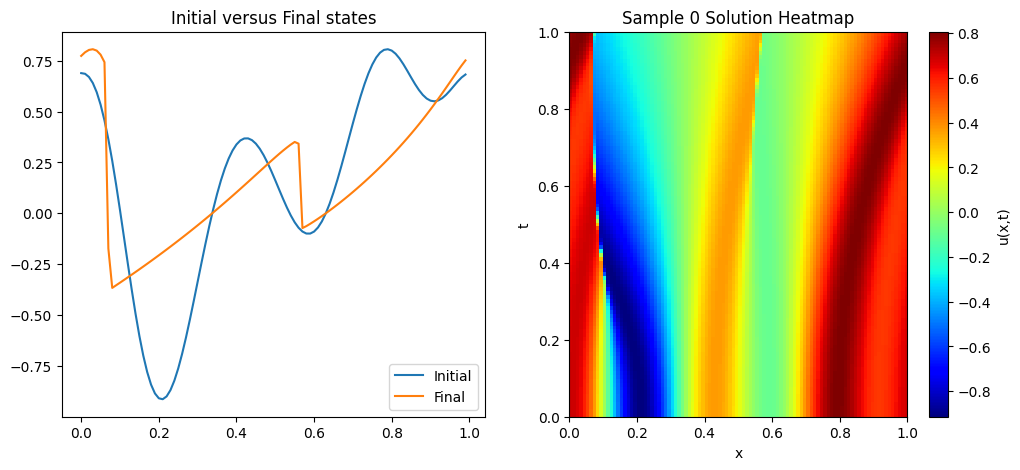

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def solve_t_traffic_sharp(u0, x_max=1.0, t_max=1.0, Nx=500, Nt=None, cfl=0.8, plot=False):
    """
    T-Traffic Solver using WENO-Z + SSP RK3 + Rusanov Flux.
    Equation: u_t + (t * (u^2/2 - u^3/6))_x = 0
    """
    """
    Robust Solver for u_t + (t * (u^2/2 - u^3/6))_x = 0
    Fixed the t=0 singularity and improved reconstruction.
    """
    
    # Grid
    x = np.linspace(0, x_max, Nx, endpoint=False)
    dx = x[1] - x[0]
    u = u0

    # --- Physics Functions ---
    def g_val(u): 
        return (u**2)/2.0 - (u**3)/6.0
    
    def g_prime_abs(u): 
        # Absolute derivative |g'(u)|
        return np.abs(u - (u**2)/2.0)

    # --- Explicit WENO-Z Reconstruction ---
    def weno_z_reconstruct(q):
        """
        Returns u_L (left of interface i+1/2) and u_R (right of interface i+1/2)
        """
        epsilon = 1e-40
        
        # Prepare 5-point stencil arrays via rolling
        # q_m2 = q[i-2], q_m1 = q[i-1], q_0 = q[i], q_p1 = q[i+1], q_p2 = q[i+2]
        q_m2 = np.roll(q, 2)
        q_m1 = np.roll(q, 1)
        q_0  = q
        q_p1 = np.roll(q, -1)
        q_p2 = np.roll(q, -2)

        # --- 1. Reconstruct u_L (u at i+1/2, biased left) ---
        # Smoothness indicators (Jiang & Shu)
        beta0 = (13/12)*(q_m2 - 2*q_m1 + q_0)**2 + 0.25*(q_m2 - 4*q_m1 + 3*q_0)**2
        beta1 = (13/12)*(q_m1 - 2*q_0 + q_p1)**2 + 0.25*(q_m1 - q_p1)**2
        beta2 = (13/12)*(q_0 - 2*q_p1 + q_p2)**2 + 0.25*(3*q_0 - 4*q_p1 + q_p2)**2
        
        # WENO-Z weights
        tau5 = np.abs(beta0 - beta2)
        a0 = 0.1 * (1 + (tau5 / (beta0 + epsilon))**2)
        a1 = 0.6 * (1 + (tau5 / (beta1 + epsilon))**2)
        a2 = 0.3 * (1 + (tau5 / (beta2 + epsilon))**2)
        w_sum = a0 + a1 + a2
        
        # Stencils
        p0 = (2*q_m2 - 7*q_m1 + 11*q_0)/6
        p1 = (-q_m1 + 5*q_0 + 2*q_p1)/6
        p2 = (2*q_0 + 5*q_p1 - q_p2)/6
        
        uL = (a0*p0 + a1*p1 + a2*p2) / w_sum

        # --- 2. Reconstruct u_R (u at i+1/2, biased right) ---
        # Symmetry trick: To get u_R at i+1/2, we perform the same logic 
        # but on the mirror image of the stencil relative to the interface.
        # Alternatively, u_R at i+1/2 is u_L at i+1/2 computed on the reversed grid?
        # Let's use the explicit formulas for u_R (Right-sided WENO)
        
        # Betas for the "right" side stencils (indices shifted +1 relative to left)
        # We want value at left face of cell i+1.
        # Uses q_m1, q_0, q_p1, q_p2, q_p3... essentially we shift everything by -1 (left)
        # and flip the weights.
        
        # Easier robust way:
        # u_R at interface i+1/2 is simply u_L at interface (i+1)-1/2 
        # calculated on the REVERSED array x -> -x.
        
        q_rev = q[::-1]
        qr_m2 = np.roll(q_rev, 2); qr_m1 = np.roll(q_rev, 1); qr_0 = q_rev
        qr_p1 = np.roll(q_rev, -1); qr_p2 = np.roll(q_rev, -2)
        
        b0 = (13/12)*(qr_m2 - 2*qr_m1 + qr_0)**2 + 0.25*(qr_m2 - 4*qr_m1 + 3*qr_0)**2
        b1 = (13/12)*(qr_m1 - 2*qr_0 + qr_p1)**2 + 0.25*(qr_m1 - qr_p1)**2
        b2 = (13/12)*(qr_0 - 2*qr_p1 + qr_p2)**2 + 0.25*(3*qr_0 - 4*qr_p1 + qr_p2)**2
        
        t5 = np.abs(b0 - b2)
        aa0 = 0.1 * (1 + (t5 / (b0 + epsilon))**2)
        aa1 = 0.6 * (1 + (t5 / (b1 + epsilon))**2)
        aa2 = 0.3 * (1 + (t5 / (b2 + epsilon))**2)
        ww_sum = aa0 + aa1 + aa2
        
        pp0 = (2*qr_m2 - 7*qr_m1 + 11*qr_0)/6
        pp1 = (-qr_m1 + 5*qr_0 + 2*qr_p1)/6
        pp2 = (2*qr_0 + 5*qr_p1 - qr_p2)/6
        
        uR_rev = (aa0*pp0 + aa1*pp1 + aa2*pp2) / ww_sum
        
        # Reverse back. 
        # uR_rev[j] corresponds to interface j+1/2 in the reversed grid.
        # In real grid, this maps to interface N-(j+1) + 1/2? 
        # Let's trust the spatial symmetry:
        # uR_rev reversed is u_plus at i-1/2.
        # We need u_plus at i+1/2. So we roll by -1.
        uR = np.roll(uR_rev[::-1], -1)

        return uL, uR

    # --- RHS Calculation ---
    def get_rhs(u, t):
        uL, uR = weno_z_reconstruct(u)
        
        # Flux = t * g(u)
        fL = t * g_val(uL)
        fR = t * g_val(uR)
        
        # Wave speeds = t * g'(u)
        # Note: We use 't' here. If t=0, flux is 0, rhs is 0. Correct.
        alpha_L = t * g_prime_abs(uL)
        alpha_R = t * g_prime_abs(uR)
        alpha = np.maximum(alpha_L, alpha_R)
        
        # Rusanov Flux
        flux_interface = 0.5 * (fL + fR - alpha * (uR - uL))
        
        return -(flux_interface - np.roll(flux_interface, 1)) / dx

    # --- Time Stepping Initialization ---
    t = 0.0
    # Calculate a SAFE constant dt based on the MAXIMUM time
    # This avoids the division by zero at t=0
    max_wave_speed_global = t_max * np.max(g_prime_abs(u)) 
    if max_wave_speed_global < 1e-6: max_wave_speed_global = 1e-6 # Safety
    
    dt = cfl * dx / max_wave_speed_global
    
    # If user wants fixed frames
    if Nt is not None:
        # If user forces Nt, we might need to adjust dt or interpolate later
        # Here we just use the fixed Nt for output interpolation
        t_out = np.linspace(0, t_max, Nt)
        u_out = np.zeros((Nt, Nx))
        u_out[0] = u.copy()
        output_idx = 1
    
    sols = [u.copy()] # For simple list output
    times = [0.0]

    # --- Main Loop ---
    while t < t_max:
        if t + dt > t_max:
            dt = t_max - t
        
        # SSP RK3
        # Stage 1
        k1 = get_rhs(u, t)
        u1 = u + dt * k1
        
        # Stage 2
        k2 = get_rhs(u1, t + dt)
        u2 = 0.75*u + 0.25*(u1 + dt * k2)
        
        # Stage 3
        k3 = get_rhs(u2, t + 0.5*dt)
        u_new = (1/3)*u + (2/3)*(u2 + dt * k3)
        
        u = u_new
        t += dt
        
        sols.append(u.copy())
        times.append(t)

    # --- Output formatting ---
    sols = np.array(sols)
    times = np.array(times)
    
    if Nt is not None:
        # Interpolate to uniform t grid
        final_grid = np.zeros((Nt, Nx))
        for i in range(Nx):
            final_grid[:, i] = np.interp(t_out, times, sols[:, i])
        sols = final_grid

    if plot:
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(x, sols[-1], 'r-', linewidth=2, label="Solution")
        plt.plot(x, ic(x), 'k--', alpha=0.5, label="Initial")
        plt.title(f"Solution at t={t_max:.2f}")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1,2,2)
        plt.imshow(sols, extent=[0, x_max, 0, t_max], origin='lower', aspect='auto', cmap='jet')
        plt.colorbar(label="u")
        plt.xlabel("x"); plt.ylabel("t")
        plt.title("Space-Time Traffic")
        plt.tight_layout()
        plt.show()

    return sols


def create_traffic_dataset(N_SAMPLES=200, Nx=128, Nt=101, X_MUL=4, T_MUL=5, LENGTH_SCALE=1.0, ics=None):
    """
    Generates dataset and returns dictionary with NumPy arrays.
    """
    print(f"Generating {N_SAMPLES} samples of time-dependent traffic equation ...")
    
    # Pre-allocate arrays
    x_data = np.zeros((N_SAMPLES, Nx))      # To store Initial Conditions
    y_data = np.zeros((N_SAMPLES, Nt, Nx))  # To store Solutions

    func_space = dde.data.GRF(kernel="ExpSineSquared", length_scale=LENGTH_SCALE)
    feats = func_space.random(N_SAMPLES)

    xs = np.linspace(0, 1, Nx*X_MUL, endpoint=False)
    if ics is not None:
        ics_all = np.zeros((N_SAMPLES, Nx*X_MUL))
        # interpolate ics to match the resolution
        x_res = ics.shape[1]
        x_grid = np.linspace(0, 1, x_res+1, endpoint=True)
        for k in range(N_SAMPLES):
            ic_pad = np.append(ics[k], ics[k][0])
            ic = interp1d(x_grid, ic_pad, "linear")
            ics_all[k] = ic(xs)

    else:  
        ics_all = func_space.eval_batch(feats, xs)
    
    for i in range(N_SAMPLES):
        if (i+1) % 50 == 0:
            print(f"Processing sample {i+1}/{N_SAMPLES}...")
            
        # 1. Generate IC
        u0 = ics_all[i]
        
        # 2. Solve
        u_sol = solve_t_traffic_sharp(u0, Nx=Nx*X_MUL, Nt=Nt, cfl=0.4)
        
        # 3. Store
        x_data[i] = u0[::X_MUL]
        y_data[i] = u_sol[:, ::X_MUL]

    # 4. Pack into dictionary (NumPy arrays only)
    traffic_128 = {
        'x': x_data,
        'y': y_data,
        'visc': np.array([[0]])
    }
    
    print("\nGeneration complete.")
    print(f"x shape: {traffic_128['x'].shape}")
    print(f"y shape: {traffic_128['y'].shape}")
    
    return traffic_128

# --- Example Usage ---
if __name__ == "__main__":
    # Generate data
    data_dict = create_traffic_dataset(N_SAMPLES=100, Nx=100, Nt=101, X_MUL=2, T_MUL=1)
    
    # Verification Plot
    sample_idx = np.random.randint(1)
    x_grid = np.linspace(0, 1, 100, endpoint=False)
    u_field = data_dict['y'][sample_idx]
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)    
    plt.plot(x_grid, u_field[0], label="Initial")
    plt.plot(x_grid, u_field[-1], label="Final")
    plt.title("Initial versus Final states")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.imshow(u_field, extent=[0, 1, 0, 1], origin="lower", aspect="auto", cmap="jet")
    plt.colorbar(label="u(x,t)")
    plt.title(f"Sample {sample_idx} Solution Heatmap")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.show()

In [3]:
# Generate data
data_dict = create_traffic_dataset(N_SAMPLES=1000, Nx=100, Nt=101, X_MUL=2, T_MUL=1)

import scipy

# We map 'x' -> 'input' and 'y' -> 'output'
mat_data = {
    'input': data_dict['x'],
    'output': data_dict['y'],
    'visc': data_dict['visc']
}

# 3. Save to .mat file
# do_compression=True helps if the arrays are large
scipy.io.savemat('/home/tp526/neuraloperator/data/traffic_pino_x100_t101_1000.mat', mat_data, do_compression=True)

print("Saved to /home/tp526/neuraloperator/data/traffic_pino_x100_t101_1000.mat")

Generating 1000 samples of time-dependent traffic equation ...
Processing sample 50/1000...
Processing sample 100/1000...
Processing sample 150/1000...
Processing sample 200/1000...
Processing sample 250/1000...
Processing sample 300/1000...
Processing sample 350/1000...
Processing sample 400/1000...
Processing sample 450/1000...
Processing sample 500/1000...
Processing sample 550/1000...
Processing sample 600/1000...
Processing sample 650/1000...
Processing sample 700/1000...
Processing sample 750/1000...
Processing sample 800/1000...
Processing sample 850/1000...
Processing sample 900/1000...
Processing sample 950/1000...
Processing sample 1000/1000...

Generation complete.
x shape: (1000, 100)
y shape: (1000, 101, 100)
Saved to /home/tp526/neuraloperator/data/traffic_pino_x100_t101_1000.mat


<h2>Test the model</h2>

In [14]:
def format_burgers_data(data_dict):
    """
    Reshapes the Burgers dataset into a coordinate-based format.
    
    Args:
        data_dict (dict): Dictionary with keys 'x' (N, Nx) and 'y' (N, Nt, Nx).
        
    Returns:
        np.array: A single array of shape (N_SAMPLES, Nt, Nx, 3).
                  Channel 0: u0(x) repeated over time
                  Channel 1: x coordinates
                  Channel 2: t coordinates
    """
    # 1. Extract dimensions
    # data_dict['x'] is the initial condition u0, shape (N, Nx)
    # data_dict['y'] is the solution u, shape (N, Nt, Nx)
    u0 = data_dict['x'] 
    N_samples, Nx = u0.shape
    Nt = data_dict['y'].shape[1]
    
    print(f"Dimensions detected: N={N_samples}, Nt={Nt}, Nx={Nx}")

    # 2. Create Mesh Grids (Nt, Nx)
    # Recreate the grids used in the solver
    x_1d = np.linspace(0, 1, Nx, endpoint=False)
    t_1d = np.linspace(0, 1, Nt)
    
    # Create 2D grids. indexing='ij' ensures output is (Nt, Nx)
    # T_grid varies along axis 0, X_grid varies along axis 1
    T_grid, X_grid = np.meshgrid(t_1d, x_1d, indexing='ij')
    
    # 3. Broadcast/Repeat Arrays to shape (N, Nt, Nx)
    
    # Channel 0: u0 (Initial Condition)
    # Input: (N, Nx) -> Expand to (N, 1, Nx) -> Tile to (N, Nt, Nx)
    u0_expanded = np.tile(u0[:, None, :], (1, Nt, 1))
    
    # Channel 1: X Grid
    # Input: (Nt, Nx) -> Expand to (1, Nt, Nx) -> Broadcast to (N, Nt, Nx)
    X_expanded = np.tile(X_grid[None, :, :], (N_samples, 1, 1))
    
    # Channel 2: T Grid
    # Input: (Nt, Nx) -> Expand to (1, Nt, Nx) -> Broadcast to (N, Nt, Nx)
    T_expanded = np.tile(T_grid[None, :, :], (N_samples, 1, 1))
    
    # 4. Stack along the last axis
    # Result shape: (N, Nt, Nx, 3, 1)
    formatted_data = np.stack([u0_expanded, X_expanded, T_expanded], axis=-1)
    
    return formatted_data

In [27]:
formatted_inputs = format_burgers_data(data_dict)
formatted_inputs.shape

Dimensions detected: N=100, Nt=101, Nx=128


(100, 101, 128, 3)

Input shape:  torch.Size([1, 101, 128, 3])
Output shape:  torch.Size([1, 101, 128])


==Relative L2 error mean:  0.348290==

Ground Truth


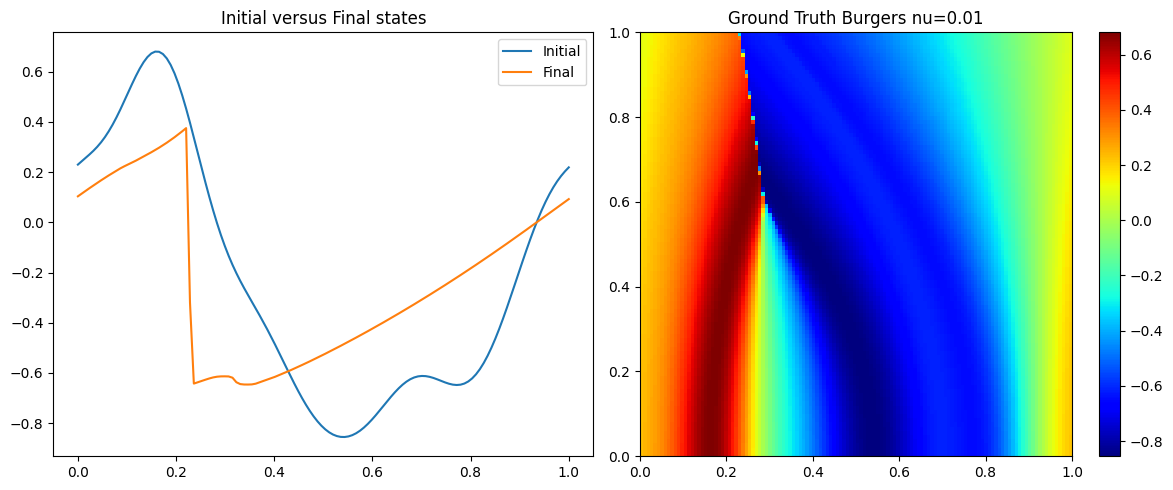

Prediction


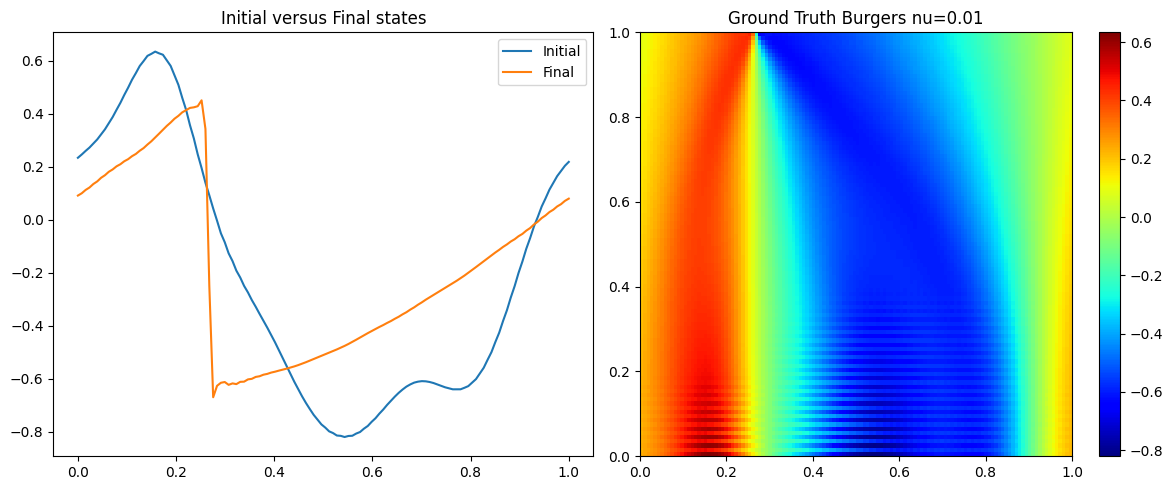

In [22]:
k = np.random.randint(10)

x, y = torch.tensor(formatted_inputs[k:k+1], dtype=torch.float32).to(device), torch.tensor(data_dict["y"][k:k+1], dtype=torch.float32).to(device)

print("Input shape: ", x.shape)
print("Output shape: ", y.shape)
print("\n")

out = model(x).reshape(y.shape)

data_loss = torch.norm(out - y) / torch.norm(y)

print(f'==Relative L2 error mean: {data_loss.item() : .6f}==\n')

# Plot
print("Ground Truth")
truth = y[0].detach().cpu().numpy()
x_grid = np.linspace(0, 1, truth.shape[1])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_grid, truth[0], label="Initial")
plt.plot(x_grid, truth[-1], label="Final")
plt.title("Initial versus Final states")
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(truth, extent=[0, 1, 0, 1], origin="lower", aspect="auto", cmap="jet")
plt.title("Ground Truth Burgers nu=0.01")
plt.colorbar()

plt.tight_layout()
plt.show()

print("Prediction")
pred = out[0].detach().cpu().numpy()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_grid, pred[0], label="Initial")
plt.plot(x_grid, pred[-1], label="Final")
plt.title("Initial versus Final states")
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(pred, extent=[0, 1, 0, 1], origin="lower", aspect="auto", cmap="jet")
plt.title("Ground Truth Burgers nu=0.01")
plt.colorbar()

plt.tight_layout()
plt.show()



In [31]:
dataset = BurgersLoader("/home/tp526/neuraloperator/data/burgers_pino.mat",
                            nx=128, nt=100,
                            sub=1, sub_t=1, new=True)
train_loader = dataset.make_loader(n_sample=10,
                                    batch_size=1,
                                    start=0)

/home/tp526/.conda/envs/dde/lib/python3.11/site-packages/scipy/io/matlab/_mio.py:235: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Considerscipy.io.matlab.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [32]:
for batch in train_loader:
    x, y = batch
    print(x.shape)

torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])


In [9]:
import scipy

# We map 'x' -> 'input' and 'y' -> 'output'
mat_data = {
    'input': data_dict['x'],
    'output': data_dict['y'],
    'visc': data_dict['visc']
}

# 3. Save to .mat file
# do_compression=True helps if the arrays are large
scipy.io.savemat('/home/tp526/neuraloperator/data/traffic_pino.mat', mat_data, do_compression=True)

print("Saved to /home/tp526/neuraloperator/data/traffic_pino.mat")

Saved to /home/tp526/neuraloperator/data/traffic_pino.mat


In [23]:
print("-" * 100)
print("\nNumber of trainable parameters: ", sum(p.numel() for p in model.parameters()))
print("\n" + "-" * 100)

----------------------------------------------------------------------------------------------------

Number of trainable parameters:  3715777

----------------------------------------------------------------------------------------------------


<h2>Test</h2>

In [28]:
#model.eval()

N_CASE = formatted_inputs.shape[0]

l2_errors = np.zeros(N_CASE)
l1_errors = np.zeros(N_CASE)

with torch.no_grad():
    for k in range(N_CASE):
        x = torch.tensor(formatted_inputs[k:k+1], dtype=torch.float32).to(device)
        y = torch.tensor(data_dict["y"][k:k+1], dtype=torch.float32).to(device)

        out = model(x).reshape(y.shape)

        # Relative L2
        l2 = torch.norm(out - y, p=2) / torch.norm(y, p=2)
        l2_errors[k] = l2.item()

        # Relative L1
        l1 = torch.norm(out - y, p=1) / torch.norm(y, p=1)
        l1_errors[k] = l1.item()

        if (k+1) % 20 == 0:
            print(f'Sample {k+1}/{N_CASE}: ')
            print(f'    Mean L2-relative-error: {np.mean(l2_errors[:(k+1)]):.6e}')
            print(f'    Mean L1-relative-error: {np.mean(l1_errors[:(k+1)]):.6e}')
            print("-" * 50 + "\n")

print(f"Mean L2-relative-error over 1000 tests: {np.mean(l2_errors):.6e}")
print(f"Mean L1-relative-error over 1000 tests: {np.mean(l1_errors):.6e}")
print(f"L2 std: {np.std(l2_errors):.6e}")
print(f"L1 std: {np.std(l1_errors):.6e}")


Sample 20/100: 
    Mean L2-relative-error: 2.869567e-01
    Mean L1-relative-error: 1.918827e-01
--------------------------------------------------

Sample 40/100: 
    Mean L2-relative-error: 2.967857e-01
    Mean L1-relative-error: 1.963202e-01
--------------------------------------------------

Sample 60/100: 
    Mean L2-relative-error: 2.908690e-01
    Mean L1-relative-error: 1.908332e-01
--------------------------------------------------

Sample 80/100: 
    Mean L2-relative-error: 2.842331e-01
    Mean L1-relative-error: 1.836919e-01
--------------------------------------------------

Sample 100/100: 
    Mean L2-relative-error: 2.905261e-01
    Mean L1-relative-error: 1.881349e-01
--------------------------------------------------

Mean L2-relative-error over 1000 tests: 2.905261e-01
Mean L1-relative-error over 1000 tests: 1.881349e-01
L2 std: 1.575743e-01
L1 std: 1.047730e-01
